### Instructions, Packages etc
- To run this notebook, you will require access to Google's Cloud Vision API. Once you've signed up for the service, directions for obtaining your key and installing the google cloud python package can be found here : https://cloud.google.com/vision/docs/libraries#client-libraries-install-python 


- To use a pretrained word2vec model, we will have to install a package called gensim.
 !pip install gensim # Run this in a cell below to install gensim directly from your notebook.


- Once you've installed gensim, download the word2vec (1.5GB) file in a directory containing this notebook and update
the location of the file in the variable called 'word2vec_location'.
Word2Vec can be downloaded from : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing


- There are two ways to scrape data from Instagram, one is through the API (the only preferred method) and the other is to use a package called instagram-scraper. For now, i'm using the latter. Please install it using:
!pip install instagram-scraper 
This is command line utility that will download all the pictures of a user to a folder of the username. You can call upon the tool from your terminal/cmd using instagram-scraper username
To run it from this notebook, use !instagram-scraper username


In [1]:
import io
import os
import gensim

# Enter the path to the word2vec .bin file
word2vec_location = 'cnn-text-classification-tf-master\data\input\word_embeddings\GoogleNews-vectors-negative300.bin'

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_location, binary=True)

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

# Instantiates a client
client = vision.ImageAnnotatorClient()

# This downloads all the photos from (my) username unsaifi and stores it in a directory of the same name.
#!instagram-scraper unsaifi

C:\Users\Saifi\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# The name of the image file to annotate
insta_username = 'usaifi'
dir_name = 'insta_data/' + str(insta_username)

In [3]:
'''
For each picture downloaded in the directory by instagram scraper, call the Google Vision API
to obtain relevant labels and stored it in a list called 'labels_list'. The overall response object
is stored in response_list
'''

response_list = []
labels_list = []

for file_name in os.listdir(dir_name):
    
    file_name = dir_name + '/' + file_name
    
    with io.open(file_name, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)

    # Performs label detection on the image file
    response = client.label_detection(image=image)
    labels = response.label_annotations
    
    response_list.append(response)
    labels_list.append(labels)
    
    print(file_name, ' Complete.')

insta_data/usaifi/10358389_830553920348572_998447672_n.jpg  Complete.
insta_data/usaifi/10832155_595030557289938_1931669367_n.jpg  Complete.
insta_data/usaifi/10865214_886439978053723_241572664_n.jpg  Complete.
insta_data/usaifi/10881908_1422253528081995_1340639662_n.jpg  Complete.
insta_data/usaifi/10964007_277524255704618_171081253_n.jpg  Complete.
insta_data/usaifi/11111282_611673628969829_916507930_n.jpg  Complete.
insta_data/usaifi/11176021_968052863204722_1884031067_n.jpg  Complete.
insta_data/usaifi/11184495_862964273762140_2143602501_n.jpg  Complete.
insta_data/usaifi/11235989_675323062593750_2006082697_n.jpg  Complete.
insta_data/usaifi/11326556_1473119742995175_1741152624_n.jpg  Complete.
insta_data/usaifi/11333720_803359583105143_478989297_n.jpg  Complete.
insta_data/usaifi/11909387_168811753459796_1341139668_n.jpg  Complete.
insta_data/usaifi/11909430_1604055319855863_1944829335_n.jpg  Complete.
insta_data/usaifi/11930802_891837984233120_1696880042_n.jpg  Complete.
insta_da

In [4]:
# Extract the descriptions found by GCVision to labels_desc

labels_desc = []
for i in labels_list:
    for j in i:
        labels_desc.append(j.description)
        
print('Example Labels : ' , labels_desc[:10])
print('Total labels obtained : ', len(labels_desc))

Example Labels :  ['light', 'line', 'wall', 'sky', 'wood', 'daylighting', 'symmetry', 'angle', 'texture', 'square']
Total labels obtained :  525


In [5]:
# Examine the frequency of labels returned for our images
from collections import Counter
# Some labels returned might have two terms in them e.g. 'christmas lights'. I choose to break these up.

labels_single = []
for i in labels_desc:
    for j in i.split():
        labels_single.append(j)
        
counts_single = Counter(labels_single)
counts_single.most_common(20)

[('sky', 23),
 ('art', 23),
 ('square', 13),
 ('tree', 12),
 ('texture', 12),
 ('atmosphere', 12),
 ('car', 11),
 ('phenomenon', 10),
 ('font', 10),
 ('yellow', 9),
 ('design', 9),
 ('dog', 9),
 ('modern', 9),
 ('photography', 9),
 ('vehicle', 8),
 ('computer', 7),
 ('painting', 7),
 ('visual', 7),
 ('arts', 7),
 ('darkness', 7)]

In [6]:
# Using the pretrained word2vec model, extract 300 dimension vectors for each word and add it to word_df for a dataframe

word_df = []
for word in set(labels_single):
    try:
        row = [word]
        word2vecmodel = model[word]
        for j in range(len(word2vecmodel)):
            row.append(word2vecmodel[j])
        word_df.append(row)
    except:
        pass

In [7]:
import pandas as pd

# Create DF, rename columns

df = pd.DataFrame(word_df)

df.rename(columns=lambda x: 'dim'+str(x) if x != 0 else 'word',inplace=True)
X = df.drop('word', axis=1)
y = df['word']

df.head(10)

,word,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,dim291,dim292,dim293,dim294,dim295,dim296,dim297,dim298,dim299,dim300
0,building,-0.009766,0.028564,0.054199,0.017944,0.055420,-0.155273,0.199219,-0.090820,0.172852,...,-0.402344,0.161133,-0.166992,0.068359,-0.119629,-0.048584,0.157227,-0.013000,0.116211,0.028198
1,phenomenon,0.326172,0.025024,-0.176758,0.160156,-0.333984,0.134766,0.062256,-0.326172,0.084473,...,0.040771,-0.177734,0.095215,-0.118164,-0.118164,-0.102051,0.106445,0.090332,0.051514,0.069824
2,line,-0.097656,0.057129,-0.009216,0.088379,-0.060547,-0.069336,-0.097656,-0.076172,-0.057861,...,0.120117,0.134766,-0.235352,0.116211,-0.007935,-0.071777,0.126953,-0.027100,-0.011353,-0.191406
3,woven,-0.005249,-0.115234,-0.211914,0.088379,-0.141602,0.007690,0.125000,0.041260,0.056641,...,-0.380859,-0.035645,-0.125977,-0.101562,-0.119141,-0.187500,0.478516,-0.225586,0.308594,0.095703
4,ancient,0.412109,0.291016,0.125000,0.031982,0.083496,0.209961,0.180664,-0.183594,-0.034180,...,-0.108398,-0.115234,-0.116699,0.065918,0.048340,0.197266,-0.098145,-0.080078,0.086426,0.151367
5,sky,0.056641,-0.033447,-0.123047,-0.063965,-0.094727,-0.117676,0.134766,-0.066895,-0.078613,...,0.155273,-0.068848,-0.103027,0.008728,-0.191406,-0.052979,0.088867,-0.135742,0.132812,-0.396484
6,attraction,0.219727,0.143555,0.018677,0.053467,-0.124023,0.203125,0.279297,-0.016602,-0.127930,...,-0.212891,0.062256,-0.024902,-0.206055,-0.120605,-0.034668,-0.045166,-0.108887,0.103516,0.009277
7,byzantine,0.052734,0.184570,-0.118652,0.275391,-0.171875,-0.096191,0.175781,-0.021606,-0.040771,...,-0.216797,-0.333984,0.140625,0.003311,-0.247070,-0.039795,0.191406,0.064453,-0.110840,0.166992
8,path,0.083496,0.138672,0.005829,0.213867,0.024902,-0.131836,0.121094,-0.412109,-0.236328,...,-0.062988,0.154297,-0.226562,0.055420,0.047363,-0.046875,0.109863,0.036865,0.032471,0.019897
9,color,-0.004303,0.143555,0.036377,0.129883,0.012756,-0.192383,0.306641,-0.249023,0.045166,...,-0.108887,0.025024,-0.103027,-0.172852,0.155273,-0.083008,-0.046387,-0.061768,0.171875,-0.091309


### PCA and t-SNE

In [8]:
'''
Run this to do PCA dimension reduction. E.g. in this notebook, I first use PCA to reduce dimensions
and then use tsne (another dimension reduction technique) to try to visualize the words
in 2 dimensions
TODO : figure out optimal number of PCA components. As an example, here i use 30.
'''

from sklearn.decomposition import PCA
pca = PCA(n_components=0.80,random_state=1234)
X_pca = pca.fit_transform(X)
X_pca2 = PCA(n_components=2,random_state=1234).fit_transform(X)

<IPython.core.display.Javascript object>


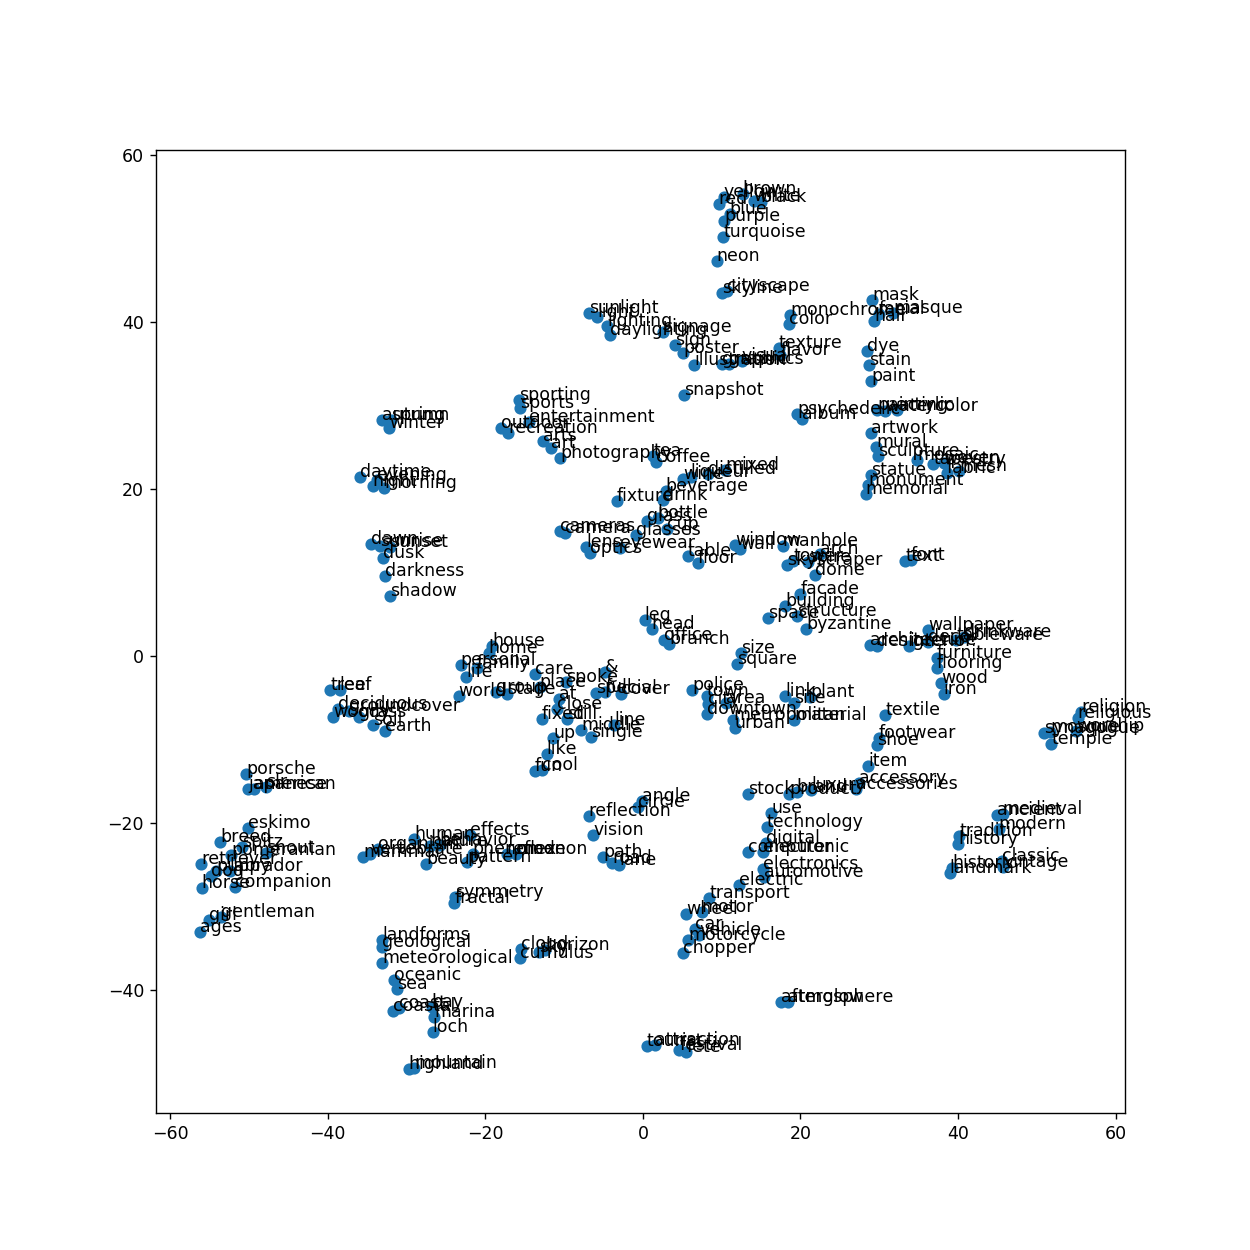

In [9]:
'''
Uses the reduced X_pca output and feeds it to 
tsne (refer to scikit docu for more info), to cut down to 2 dimensions and visualize.
You can try using X instead of the PCA output to see if you obtain
better results
'''

%matplotlib notebook
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# We can change parameters here, i just use this as an example
tsne = TSNE(n_components=2,metric='cosine',perplexity=5,)

# Change X_pca to X if you want to run it on the whole 300 dimension data instead of the pca output
X_tsne = tsne.fit_transform(X_pca)

plt.rcParams["figure.figsize"] = (10,10)

fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],)
for i, txt in enumerate(df['word']):
    ax.annotate(txt, (X_tsne[i,0],X_tsne[i,1]))


The previous steps were straight forward. We obtain labels and tags from Google of an image we obtain from Instagram. We then run these labels through a pre-trained word2vec. This returns 300 dimensions for each word and we proceed to reduce dimensions. We use PCA and t-sne to reduce it down to 2 dimensions as seen in the chart above.

The next, more pertinent question would be, how do we better summarize different regions of similar words to come up with a concise yet meaningful picture of what a person's pictures tells about them.

One approach could be to first use some sort of clustering algorithm. Once you have identified different clusters of words, you could possibly take their centroid values to get a textual representation of what the cluster might mean. While this would be a good way to summarize the main terms that come up in our labels, we would also be losing a lot of information during this process. 


TODO : Need more ideas for dealing with this. 
Example of the point above implemented using a clustering algo called Affinity Propogation.

In [10]:
'''
# Compute Affinity Propagation
# Again, you could use the 2-d tsne data (X_tsne) or X_pca or the original data X
af = AffinityPropagation(affinity='precomputed',max_iter=1500,convergence_iter=25).fit(cosine_similarity(X_tsne))
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

print('Words that represent the center points of the clusters : ')
print(df.loc[af.cluster_centers_indices_][['word']].values)
'''

'\n# Compute Affinity Propagation\n# Again, you could use the 2-d tsne data (X_tsne) or X_pca or the original data X\naf = AffinityPropagation(affinity=\'precomputed\',max_iter=1500,convergence_iter=25).fit(cosine_similarity(X_tsne))\ncluster_centers_indices = af.cluster_centers_indices_\nlabels = af.labels_\n\nn_clusters_ = len(cluster_centers_indices)\nprint(\'Estimated number of clusters: %d\' % n_clusters_)\nprint("Silhouette Coefficient: %0.3f"\n      % metrics.silhouette_score(X, labels, metric=\'sqeuclidean\'))\n\nprint(\'Words that represent the center points of the clusters : \')\nprint(df.loc[af.cluster_centers_indices_][[\'word\']].values)\n'

I don't think the words above are really representative at all of my profile. This could however just be an issue with my specific profile. I think we need to keep experimenting with different techniques here.

Further experiments using Affinity Prop and Agglomerative Clustering below. Comment out the algo you want to use below.

Estimated number of clusters: 46
Silhouette Coefficient: -0.116


<IPython.core.display.Javascript object>


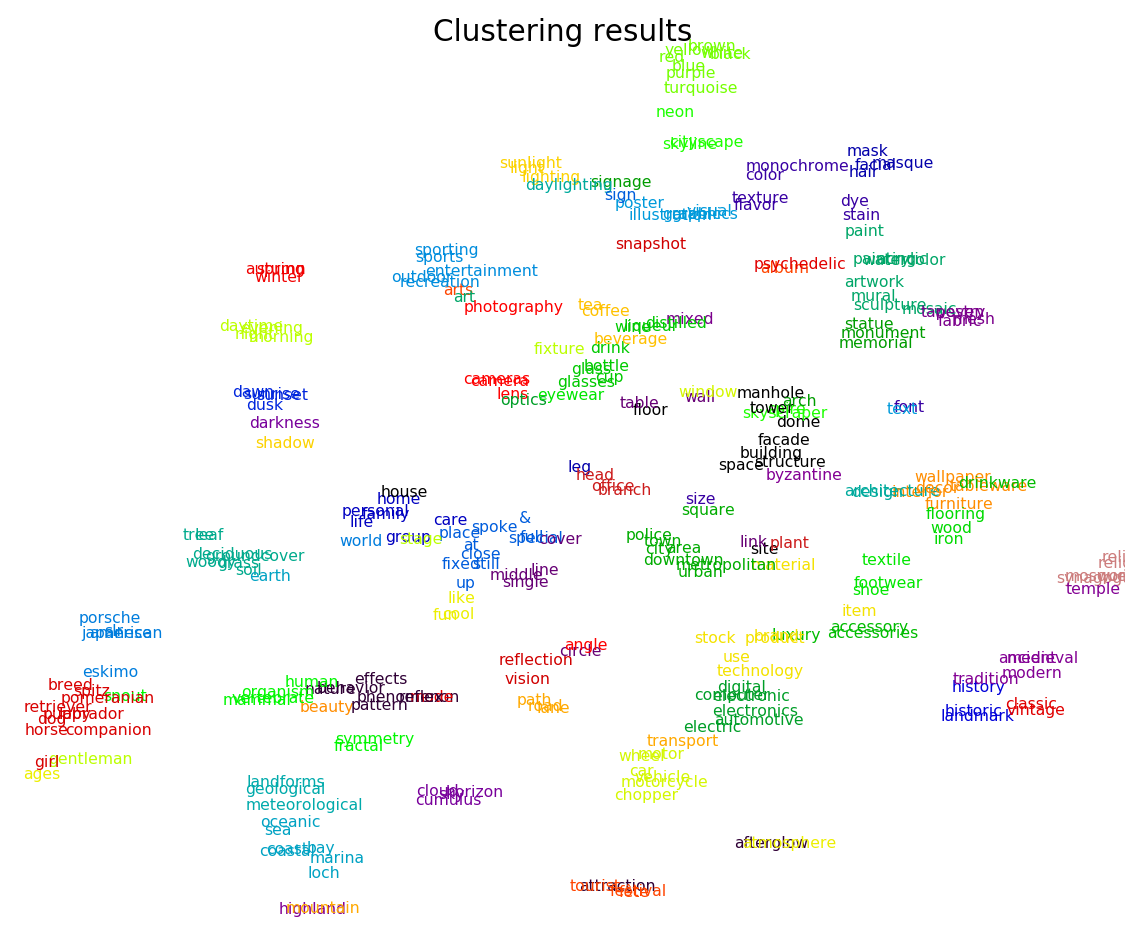

In [17]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cluster

n_samples, n_features = X.shape
np.random.seed(0)


# Function to visualize the clustering
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(9, 7.5))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / len(set(clustering.labels_))),
                 fontdict={'size': 9 }) #df.merge(df_counts,on='word')[df['word'] == y[i]][['count']].values[0]*2.5})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

clustering = cluster.AffinityPropagation(max_iter=1500,damping=0.9,affinity='precomputed').fit(cosine_similarity(X_pca))

n_clusters_ = len(clustering.cluster_centers_indices_)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_tsne, clustering.labels_, metric='sqeuclidean'))

plot_clustering(X_tsne, X, clustering.labels_, title='Clustering results')
plt.show()

## Check words in each individual cluster

In [13]:
for i in range(len(set(clustering.labels_))):
    print('\nCluster #' + str(i))
    print(df.loc[clustering.labels_ == i][['word']].values)


Cluster #0
[['building']
 ['site']
 ['manhole']
 ['dome']
 ['facade']
 ['structure']
 ['floor']
 ['house']
 ['tower']
 ['space']]

Cluster #1
[['phenomenon']
 ['attraction']
 ['behavior']
 ['afterglow']
 ['nature']
 ['reflex']
 ['effects']
 ['pattern']]

Cluster #2
[['line']
 ['wall']
 ['cover']
 ['middle']
 ['circle']
 ['single']
 ['table']
 ['link']]

Cluster #3
[['woven']
 ['mixed']
 ['mesh']
 ['fabric']
 ['tapestry']]

Cluster #4
[['ancient']
 ['byzantine']
 ['highland']
 ['modern']
 ['tradition']
 ['medieval']
 ['temple']]

Cluster #5
[['sky']
 ['cumulus']
 ['horizon']
 ['darkness']
 ['cloud']]

Cluster #6
[['color']
 ['font']
 ['monochrome']
 ['texture']
 ['size']
 ['dye']
 ['stain']
 ['flavor']]

Cluster #7
[['facial']
 ['hair']
 ['mask']
 ['leg']
 ['masque']]

Cluster #8
[['group']
 ['care']
 ['family']
 ['personal']
 ['home']
 ['life']]

Cluster #9
[['historic']
 ['landmark']
 ['history']]

Cluster #10
[['dawn']
 ['sunrise']
 ['dusk']
 ['sunset']]

Cluster #11
[['special']
 [

In [18]:
for i in range(len(set(clustering.labels_))):
    print(model.similar_by_vector(df.loc[clustering.labels_ == i].drop(columns='word').mean(axis=0).values,topn=1))

[('building', 0.745607316493988)]
[('phenomenon', 0.718063473701477)]
[('wall', 0.6133356094360352)]
[('woven', 0.8047219514846802)]
[('ancient', 0.8293473124504089)]
[('clouds', 0.8046460151672363)]
[('color', 0.7849774956703186)]
[('facial', 0.7727072238922119)]
[('family', 0.7332346439361572)]
[('historic', 0.855953574180603)]
[('sunrise', 0.8932416439056396)]
[('close', 0.5650904178619385)]
[('japanese', 0.7928862571716309)]
[('sports', 0.7926323413848877)]
[('graphic', 0.8065462708473206)]
[('ocean', 0.7814810276031494)]
[('geological', 0.8244754076004028)]
[('design', 0.7931769490242004)]
[('shrub', 0.8236362934112549)]
[('painting', 0.8515852689743042)]
[('electronics', 0.7953241467475891)]
[('monument', 0.8895514607429504)]
[('city', 0.7954533100128174)]
[('accessories', 0.8295633792877197)]
[('bottle', 0.7991527318954468)]
[('wood', 0.8714743852615356)]
[('footwear', 0.8761504888534546)]
[('vertebrate', 0.7992554306983948)]
[('skyline', 0.8677324652671814)]
[('blue', 0.8633179

In [14]:
cluster_freq = []
for i in range(len(set(clustering.labels_))):

    for w in df.loc[clustering.labels_ == i][['word']].values:
        d = {'word' : w[0], 'cluster': str('cluster') + str(i), 'freq' : counts_single[w[0]]}
        cluster_freq.append(d)

<IPython.core.display.Javascript object>


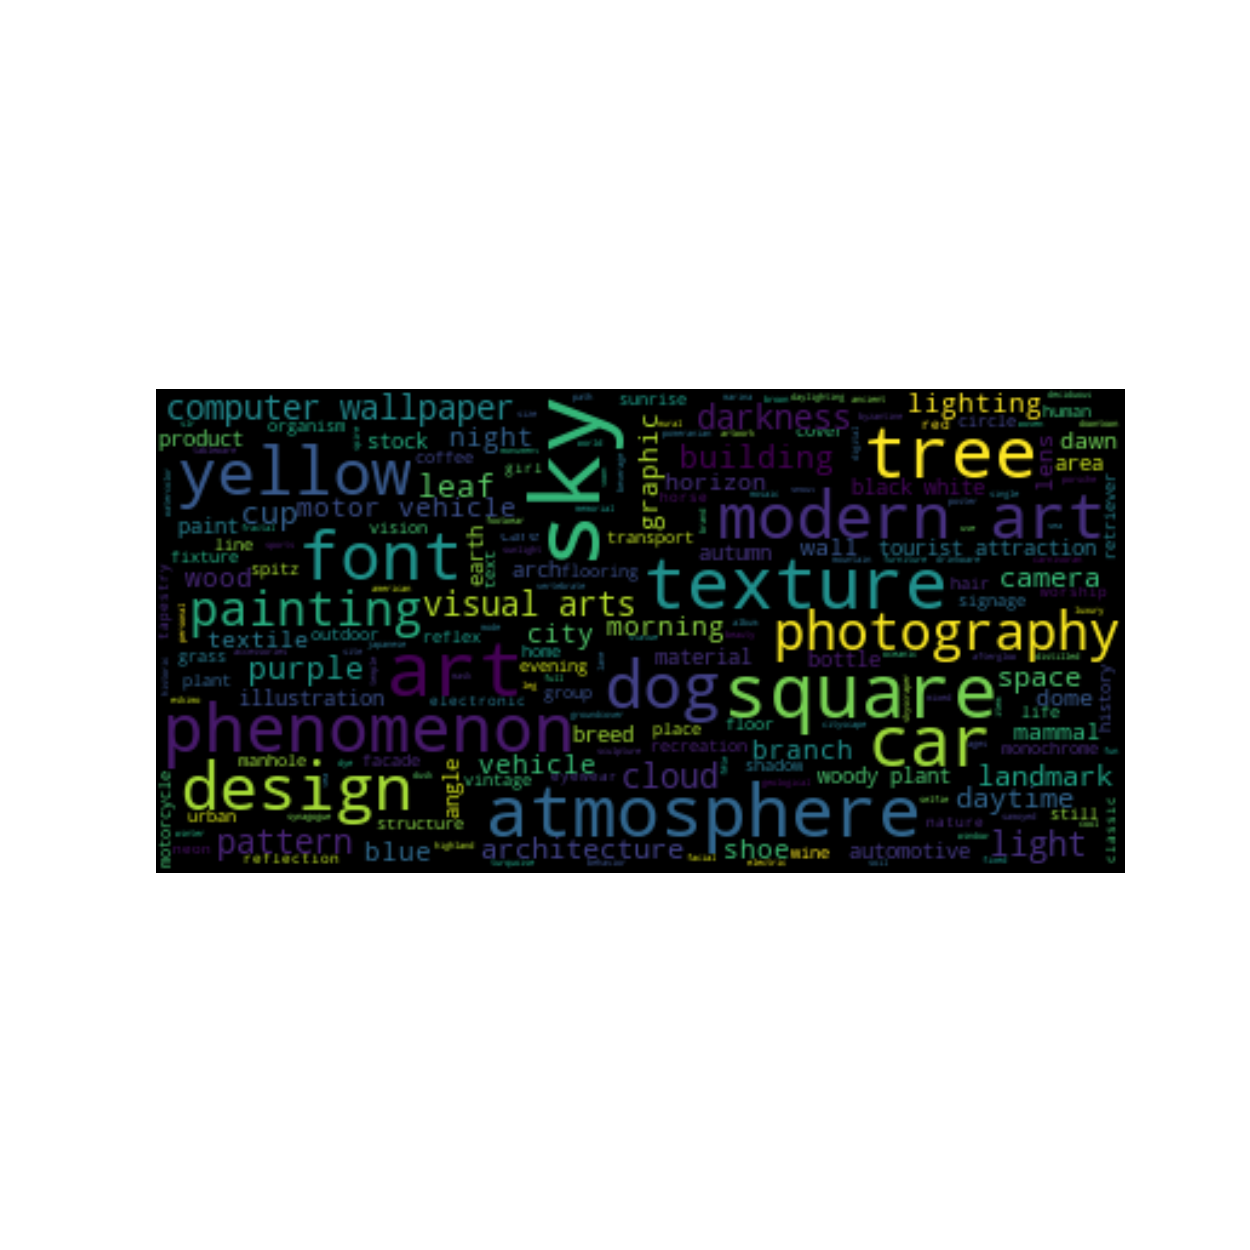

In [16]:
from os import path
from wordcloud import WordCloud

# Read the whole text.
text = ' '.join([i for i in labels_single])

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()